# Analyze grid search results to identigy the best models

In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
State = '_Connecticut'
State = ''

for initial_state in ['A', 'D', 'U']:
    print(f'\nInitial state: {initial_state}')
    for model in ['mlp']: #['xgb', 'mlp']:
        model_path = f'../Results/Grid_search/grid_search_log_{model}{State}_thermal_{initial_state}.csv'
        grid_search_df = pd.read_csv(model_path)
        grid_search_df = grid_search_df.loc[grid_search_df['level']=='L3-full']
        best_idx = grid_search_df['min_val_loss'].idxmin()
        best_row = grid_search_df.loc[best_idx]

        score = best_row['min_val_loss']
        build_params = best_row['build_params'].replace(';', ',').replace('true', 'True').replace('false', 'False')
        training_params = best_row['train_params'].replace(';', ',').replace('true', 'True').replace('false', 'False')
        print(f'   {model}')
        print(f'       Cross-entropy: {score}')
        print(f'        build_kw = {build_params}')
        print(f'        train_kw = {training_params}')


Initial state: A
   mlp
       Cross-entropy: 0.0049166473558352
        build_kw = {"activations": ["relu", "relu", "relu", "relu", "relu"], "feature_cols": ["1d_load_sum", "24h_max_load", "24h_min_load", "2d_load_sum", "CDD", "CDD3d", "DayOfWeek_cos", "DayOfWeek_sin", "DayOfYear_cos", "DayOfYear_sin", "Dew_point_temperature", "Extreme_cold", "Extreme_heat", "FDD", "FDD3d", "HDD", "HDD3d", "Heat_index", "Heat_index_isnan", "Holiday", "Hourly_load_change", "Load", "Month_cos", "Month_sin", "Precip_1d", "Precip_3d", "Precipitation", "Pressure_3hr_change", "Relative_humidity", "Sea_level_pressure", "Season_cos", "Season_sin", "Snow_depth", "State_ALABAMA", "State_ARIZONA", "State_ARKANSAS", "State_CALIFORNIA", "State_COLORADO", "State_CONNECTICUT", "State_DELAWARE", "State_FLORIDA", "State_GEORGIA", "State_IDAHO", "State_ILLINOIS", "State_INDIANA", "State_IOWA", "State_KANSAS", "State_KENTUCKY", "State_LOUISIANA", "State_MAINE", "State_MARYLAND", "State_MASSACHUSETTS", "State_MICHIGAN",

In [31]:
best_idx = grid_search_df['min_val_loss'].idxmin()
best_row = grid_search_df.loc[best_idx]
print(best_row)

level                                                     L3-full
model_name                                           xgboostModel
build_params    {"device": "cuda"; "early_stopping_rounds": 10...
train_params                               {"weights_data": true}
min_val_loss                                             0.065329
timestamp                        2025-11-06T09:51:06.595458-05:00
Name: 1014, dtype: object


In [10]:
State = '_New York'
# State = ''

for initial_state in ['A', 'D', 'U']:
    for end_state in ['A', 'D', 'U', 'all']:
        if initial_state == end_state:
            continue
        print(f'\n{initial_state} -> {end_state}')
        try:
            for model in ['mlp']: #['xgb', 'mlp']:
                model_path = f'../Results/Grid_search/grid_search_log_{model}{State}_thermal_{initial_state}_{end_state}.csv'
                grid_search_df = pd.read_csv(model_path)
                grid_search_df = grid_search_df.loc[grid_search_df['level']=='L3-full']
                best_idx = grid_search_df['min_val_loss'].idxmin()
                best_row = grid_search_df.loc[best_idx]

                score = best_row['min_val_loss']
                build_params = best_row['build_params'].replace(';', ',').replace('true', 'True').replace('false', 'False')
                training_params = best_row['train_params'].replace(';', ',').replace('true', 'True').replace('false', 'False')
                print(f'   {model}')
                print(f'       Cross-entropy: {score}')
                print(f'        build_kw = {build_params}')
                print(f'        train_kw = {training_params}')
        except FileNotFoundError:
            print('   No results found.')


A -> D
   mlp
       Cross-entropy: 0.0007056008310476
        build_kw = {"activations": ["relu", "relu", "relu", "relu", "relu", "relu", "relu", "relu", "relu", "relu"], "feature_cols": ["1d_load_sum", "24h_max_load", "24h_min_load", "2d_load_sum", "CDD", "CDD3d", "DayOfWeek_cos", "DayOfWeek_sin", "DayOfYear_cos", "DayOfYear_sin", "Dew_point_temperature", "Extreme_cold", "Extreme_heat", "FDD", "FDD3d", "HDD", "HDD3d", "Heat_index", "Heat_index_isnan", "Holiday", "Hourly_load_change", "Load", "Month_cos", "Month_sin", "Precip_1d", "Precip_3d", "Precipitation", "Pressure_3hr_change", "Relative_humidity", "Sea_level_pressure", "Season_cos", "Season_sin", "Snow_depth", "Station_level_pressure", "Temperature", "Tmax", "Tmean", "Tmin", "Weekend", "Wet_bulb_temperature", "Wind_chill", "Wind_chill_isnan", "Wind_speed"], "hidden_sizes": [256, 512, 512, 256, 128, 64, 64, 64, 64, 64], "num_classes": 2, "target_cols": ["Final_gen_state"]}
        train_kw = {"batch_size": 512, "device": "cuda",

# Grid search focal loss

In [4]:
def string2dict(s: str) -> dict:
    s = s.split(';')
    d = {}
    key = None
    value = None
    cont = False
    for item in s:
        if ':' in item:
            if value is not None and key is not None:
                raise ValueError('Unexpected format')
            k,v = item.split(':')
            k = k.replace('{', '').replace('}', '').replace('"', '').strip()
            v = v.replace('{', '').replace('}', '').replace('"', '').strip()
            if '[' in v:
                if not ']' in v:
                    cont = True
                key = k
                value = []
                v = v.replace('[', '').replace(']', '').strip()
                if v == 'false':
                    value.append(False)
                elif v == 'true':
                    value.append(True)
                elif '.' in v:
                    try:
                        value.append(float(v))
                    except:
                        value.append(v)
                elif v != '':
                    try:
                        value.append(int(v))
                    except:
                        value.append(v)
            else:
                key = k
                if v == 'false':
                    value = False
                elif v == 'true':
                    value = True
                elif '.' in v:
                    try:
                        value = float(v)
                    except:
                        value = v
                elif v != '':
                    try:
                        value = int(v)
                    except:
                        value = v
        else:
            if ']' in item:
                cont = False
            v = item.replace(']', '').replace('{', '').replace('}', '').replace('"', '').strip()
            if v == 'false':
                value.append(False)
            elif v == 'true':
                value.append(True)
            elif '.' in v:
                    try:
                        value.append(float(v))
                    except:
                        value.append(v)
            elif v != '':
                try:
                    value.append(int(v))
                except:
                    value.append(v)
            if ']' in item:
                cont = False
        
        if not cont:
            if type(value) == list:
                value = tuple(value)
            d[key] = value
            key = None
            value = None
    return d

In [5]:
def get_grid_search_df(path:str) -> pd.DataFrame:
    grid_search_raw_df = pd.read_csv(path)
    cols = ['level', 'model_name', 'state', 'reweight_train_data_density', 'min_val_loss', 'timestamp']
    data_dict = defaultdict(list)
    for idx,row in grid_search_raw_df.iterrows():
        data_dict['index'].append(idx)
        for col in cols:
            data_dict[col].append(getattr(row, col))
        build_params = string2dict(row['build_params'])
        train_params = string2dict(row['train_params'])
        for k, v in build_params.items():
            data_dict[f'build_{k}'].append(v)
        for k, v in train_params.items():
            data_dict[f'train_{k}'].append(v)
    grid_search_df = pd.DataFrame(data_dict)
    
    return grid_search_df, grid_search_raw_df

In [6]:
grid_search_focal_loss, grid_search_raw_df = get_grid_search_df('../Results/Grid_search/grid_search_log_mlp_California_thermal_A.csv')

In [7]:
grid_search_raw_df

,level,model_name,build_params,train_params,state,reweight_train_data_density,min_val_loss,timestamp
0,L3-full,MLP,"{""activations"": [""relu""; ""relu""; ""relu""; ""relu...","{""batch_size"": 512; ""device"": ""cuda""; ""early_s...",NaN,Temperature,0.007611,2025-11-19T13:28:33.353922-05:00
1,L3-full,MLP,"{""activations"": [""relu""; ""relu""; ""relu""; ""relu...","{""batch_size"": 512; ""device"": ""cuda""; ""early_s...",NaN,Temperature,NaN,2025-11-19T13:28:37.066079-05:00
2,L3-full,MLP,"{""activations"": [""relu""; ""relu""; ""relu""; ""relu...","{""batch_size"": 512; ""device"": ""cuda""; ""early_s...",NaN,Temperature,NaN,2025-11-19T13:28:40.755731-05:00
3,L3-full,MLP,"{""activations"": [""relu""; ""relu""; ""relu""; ""relu...","{""batch_size"": 512; ""device"": ""cuda""; ""early_s...",NaN,Temperature,NaN,2025-11-19T13:28:44.455052-05:00
4,L3-full,MLP,"{""activations"": [""relu""; ""relu""; ""relu""; ""relu...","{""batch_size"": 512; ""device"": ""cuda""; ""early_s...",NaN,Temperature,0.007618,2025-11-19T13:29:41.506651-05:00
...,...,...,...,...,...,...,...,...
5005,L3-full,MLP,"{""activations"": [""relu""; ""relu""; ""relu""; ""relu...","{""batch_size"": 512; ""device"": ""cuda""; ""early_s...",NaN,Temperature,0.007520,2025-11-19T22:43:40.600791-05:00
5006,L3-full,MLP,"{""activations"": [""relu""; ""relu""; ""relu""; ""relu...","{""batch_size"": 512; ""device"": ""cuda""; ""early_s...",NaN,Temperature,NaN,2025-11-19T22:43:48.272244-05:00
5007,L3-full,MLP,"{""activations"": [""relu""; ""relu""; ""relu""; ""relu...","{""batch_size"": 512; ""device"": ""cuda""; ""early_s...",NaN,Temperature,0.007447,2025-11-19T22:43:49.702167-05:00
5008,L3-full,MLP,"{""activations"": [""relu""; ""relu""; ""relu""; ""relu...","{""batch_size"": 512; ""device"": ""cuda""; ""early_s...",NaN,Temperature,0.007643,2025-11-19T22:43:55.365204-05:00


### Cross entropy baseline

In [8]:
cross_entropy_df = grid_search_focal_loss.loc[((grid_search_focal_loss['train_focal_loss_gamma_schedule']=='constant')
                                               & (grid_search_focal_loss['train_focal_loss_gamma']==0.0)
                                               & (grid_search_focal_loss['train_focal_loss_alpha']==(1.0, 1.0, 1.0))
                                               & (grid_search_focal_loss['train_focal_loss_alpha_schedule']=='constant'))].copy().reset_index(drop=True)

best_ce = cross_entropy_df.iloc[cross_entropy_df['min_val_loss'].idxmin()]
print('Best cross-entropy model:')
print(best_ce)
idx = best_ce['index']
print(f"\nInitial df row index: {idx}")
raw_row = grid_search_raw_df.loc[idx]
build_kw = raw_row['build_params'].replace(';', ',').replace('true', 'True').replace('false', 'False')
train_kw = raw_row['train_params'].replace(';', ',').replace('true', 'True').replace('false', 'False')
print(f'Build params: {build_kw}')
print(f'Train params: {train_kw}')

Best cross-entropy model:
index                                                                           3356
level                                                                        L3-full
model_name                                                                       MLP
state                                                                            NaN
reweight_train_data_density                                              Temperature
min_val_loss                                                                0.007414
timestamp                                           2025-11-19T20:14:43.695607-05:00
build_activations                  (relu, relu, relu, relu, relu, relu, relu, rel...
build_feature_cols                 (1d_load_sum, 24h_max_load, 24h_min_load, 2d_l...
build_hidden_sizes                 (128, 128, 64, 64, 64, 64, 64, 64, 64, 64, 64,...
build_num_classes                                                                  3
build_target_cols                      

### focal loss with scheduling

In [222]:
for gamma_schedule in ['constant', 'linear', 'exponential', 'cosine']:
    filtered_df = grid_search_focal_loss.loc[((grid_search_focal_loss['train_focal_loss_gamma_schedule']==gamma_schedule)
                                            & (grid_search_focal_loss['train_focal_loss_gamma']!=0.0))].copy().reset_index(drop=True)
    best = filtered_df.iloc[filtered_df['min_val_loss'].idxmin()]
    score = best['min_val_loss']
    print(f'\nBest focal loss model with gamma schedule {gamma_schedule}: {score}')
    
    idx = best['index']
    
    raw_row = grid_search_raw_df.loc[idx]
    build_kw = raw_row['build_params'].replace(';', ',').replace('true', 'True').replace('false', 'False')
    train_kw = raw_row['train_params'].replace(';', ',').replace('true', 'True').replace('false', 'False')
    print(f'        build_kw = {build_kw}')
    print(f'        train_kw = {train_kw}')



Best focal loss model with gamma schedule constant: 0.0073930796607733
        build_kw = {"activations": ["relu", "relu", "relu", "relu", "relu", "relu", "relu", "relu", "relu", "relu", "relu", "relu"], "feature_cols": ["1d_load_sum", "24h_max_load", "24h_min_load", "2d_load_sum", "CDD", "CDD3d", "DayOfWeek_cos", "DayOfWeek_sin", "DayOfYear_cos", "DayOfYear_sin", "Dew_point_temperature", "Extreme_cold", "Extreme_heat", "FDD", "FDD3d", "HDD", "HDD3d", "Heat_index", "Heat_index_isnan", "Holiday", "Hourly_load_change", "Load", "Month_cos", "Month_sin", "Precip_1d", "Precip_3d", "Precipitation", "Pressure_3hr_change", "Relative_humidity", "Sea_level_pressure", "Season_cos", "Season_sin", "Snow_depth", "Station_level_pressure", "Temperature", "Tmax", "Tmean", "Tmin", "Weekend", "Wet_bulb_temperature", "Wind_chill", "Wind_chill_isnan", "Wind_speed"], "hidden_sizes": [128, 128, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64], "num_classes": 3, "target_cols": ["Final_gen_state"]}
        train_kw = 

### Models comparison

In [200]:
grid_search_focal_loss['train_focal_loss_gamma_schedule'].unique()

array(['constant', 'linear', 'exponential', 'cosine'], dtype=object)

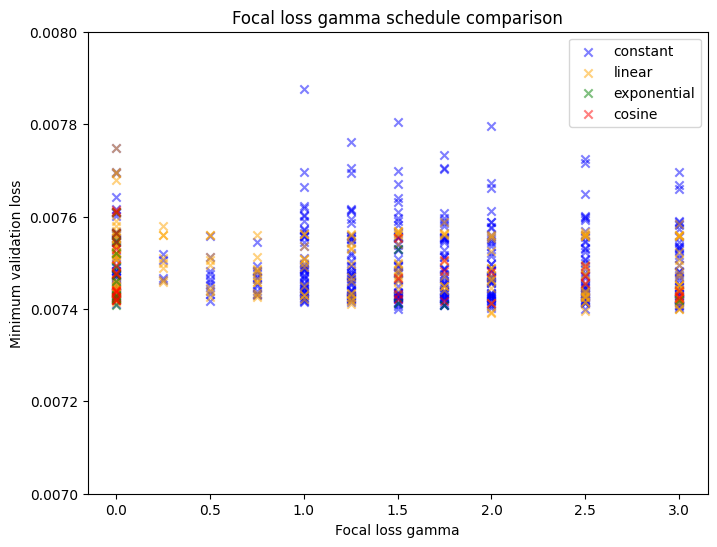

In [214]:
# compare different gammas
colors = {'constant': 'blue', 'linear': 'orange', 'exponential': 'green', 'cosine': 'red'}
fig, ax = plt.subplots(figsize=(8,6))
for schedule in grid_search_focal_loss['train_focal_loss_gamma_schedule'].unique():
    schedule_df = grid_search_focal_loss.loc[grid_search_focal_loss['train_focal_loss_gamma_schedule']==schedule]
    ax.scatter(schedule_df['train_focal_loss_gamma'], schedule_df['min_val_loss'], color=colors[schedule], marker='x', label=schedule, alpha=0.5)
ax.set_xlabel('Focal loss gamma')
ax.set_ylabel('Minimum validation loss')
ax.set_ylim(bottom=0.007, top=0.008)
ax.set_title('Focal loss gamma schedule comparison')
# ax.set_yscale('log')
ax.legend()

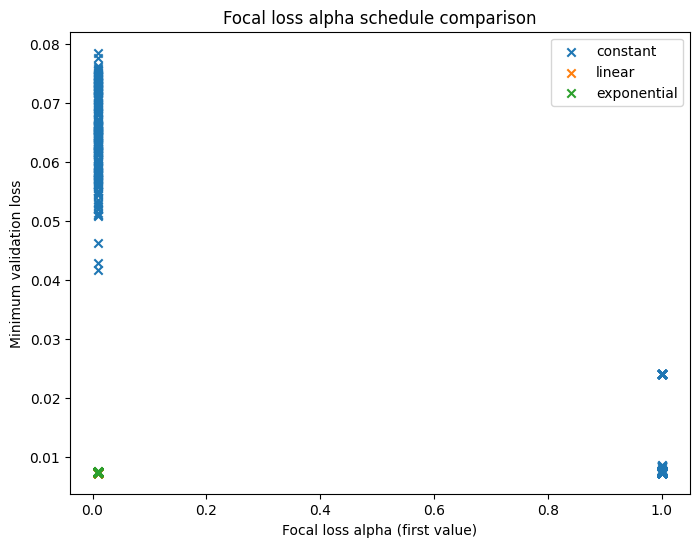

In [211]:
# Compare different alphas
fig, ax = plt.subplots(figsize=(8,6))
for schedule in grid_search_focal_loss['train_focal_loss_alpha_schedule'].unique():
    schedule_df = grid_search_focal_loss.loc[grid_search_focal_loss['train_focal_loss_alpha_schedule']==schedule]
    alphas = schedule_df['train_focal_loss_alpha'].apply(lambda x: x[0] if type(x)==tuple else x)
    ax.scatter(alphas, schedule_df['min_val_loss'], marker='x', label=schedule)
ax.set_xlabel('Focal loss alpha (first value)')
ax.set_ylabel('Minimum validation loss')
ax.set_title('Focal loss alpha schedule comparison')
# ax.set_yscale('log')
ax.legend()

# Junk

In [ ]:
get_grid_search_df

In [12]:
State = '_New York'
# State = ''
grid_searches = {}
grid_searches_raw = {}
for initial_state in ['A', 'D', 'U']:
    for end_state in ['A', 'D', 'U', 'all']:
        if initial_state == end_state:
            continue
        print(f'\n{initial_state} -> {end_state}')
        try:
            for model in ['mlp']: #['xgb', 'mlp']:
                model_path = f'../Results/Grid_search/grid_search_log_{model}{State}_thermal_{initial_state}_{end_state}.csv'
                grid_search_df, grid_search_raw_df = get_grid_search_df(model_path)
                grid_searches[(initial_state, end_state, model)] = grid_search_df
                grid_searches_raw[(initial_state, end_state, model)] = grid_search_raw_df
        except FileNotFoundError:
            print('   No results found.')


A -> D

A -> U

A -> all

D -> A

D -> U

D -> all
   No results found.

U -> A

U -> D

U -> all
   No results found.


In [16]:
df = grid_searches[('A', 'D', 'mlp')]
df

,index,level,model_name,state,reweight_train_data_density,min_val_loss,timestamp,build_activations,build_feature_cols,build_hidden_sizes,...,train_focal_loss_gamma,train_focal_loss_gamma_schedule,train_grad_clip_norm,train_lambda_reg,train_loss,train_lr,train_lr_scheduler,train_optimizer,train_regularization_type,train_weights_data
0,0,L3-full,MLP,NaN,Temperature,0.000760,2025-11-20T20:37:52.556136-05:00,"(relu, relu, relu, relu, relu, relu, relu, rel...","(1d_load_sum, 24h_max_load, 24h_min_load, 2d_l...","(256, 512, 512, 256, 128, 64, 64, 64, 64, 64)",...,0.00,constant,1.0,0.050,focal_loss,5e-05,constant,adam,L2,True
1,1,L3-full,MLP,NaN,Temperature,0.000772,2025-11-20T20:39:47.682440-05:00,"(relu, relu, relu, relu, relu, relu, relu, rel...","(1d_load_sum, 24h_max_load, 24h_min_load, 2d_l...","(256, 512, 512, 256, 128, 64, 64, 64, 64, 64)",...,0.00,constant,1.0,0.050,focal_loss,5e-05,linear,adam,L2,True
2,2,L3-full,MLP,NaN,Temperature,0.000890,2025-11-20T20:41:44.666838-05:00,"(relu, relu, relu, relu, relu, relu, relu, rel...","(1d_load_sum, 24h_max_load, 24h_min_load, 2d_l...","(256, 512, 512, 256, 128, 64, 64, 64, 64, 64)",...,0.00,constant,1.0,0.050,focal_loss,5e-05,exponential,adam,L2,True
3,3,L3-full,MLP,NaN,Temperature,0.000774,2025-11-20T20:43:41.517771-05:00,"(relu, relu, relu, relu, relu, relu, relu, rel...","(1d_load_sum, 24h_max_load, 24h_min_load, 2d_l...","(256, 512, 512, 256, 128, 64, 64, 64, 64, 64)",...,0.00,constant,1.0,0.050,focal_loss,5e-05,cosine,adam,L2,True
4,4,L3-full,MLP,NaN,Temperature,NaN,2025-11-20T20:43:44.101059-05:00,"(relu, relu, relu, relu, relu, relu, relu, rel...","(1d_load_sum, 24h_max_load, 24h_min_load, 2d_l...","(256, 512, 512, 256, 128, 64, 64, 64, 64, 64)",...,0.25,constant,1.0,0.050,focal_loss,5e-05,constant,adam,L2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,715,L3-full,MLP,NaN,Temperature,0.000722,2025-11-21T13:10:08.751987-05:00,"(relu, relu, relu, relu, relu, relu, relu, rel...","(1d_load_sum, 24h_max_load, 24h_min_load, 2d_l...","(256, 512, 512, 256, 128, 64, 64, 64, 64, 64)",...,1.25,constant,1.0,0.005,focal_loss,5e-05,constant,adam,L2,True
716,716,L3-full,MLP,NaN,Temperature,0.000727,2025-11-21T13:12:06.854126-05:00,"(relu, relu, relu, relu, relu, relu, relu, rel...","(1d_load_sum, 24h_max_load, 24h_min_load, 2d_l...","(256, 512, 512, 256, 128, 64, 64, 64, 64, 64)",...,1.25,constant,1.0,0.005,focal_loss,5e-05,linear,adam,L2,True
717,717,L3-full,MLP,NaN,Temperature,0.000851,2025-11-21T13:14:03.611672-05:00,"(relu, relu, relu, relu, relu, relu, relu, rel...","(1d_load_sum, 24h_max_load, 24h_min_load, 2d_l...","(256, 512, 512, 256, 128, 64, 64, 64, 64, 64)",...,1.25,constant,1.0,0.005,focal_loss,5e-05,exponential,adam,L2,True
718,718,L3-full,MLP,NaN,Temperature,0.000729,2025-11-21T13:16:01.860052-05:00,"(relu, relu, relu, relu, relu, relu, relu, rel...","(1d_load_sum, 24h_max_load, 24h_min_load, 2d_l...","(256, 512, 512, 256, 128, 64, 64, 64, 64, 64)",...,1.25,constant,1.0,0.005,focal_loss,5e-05,cosine,adam,L2,True


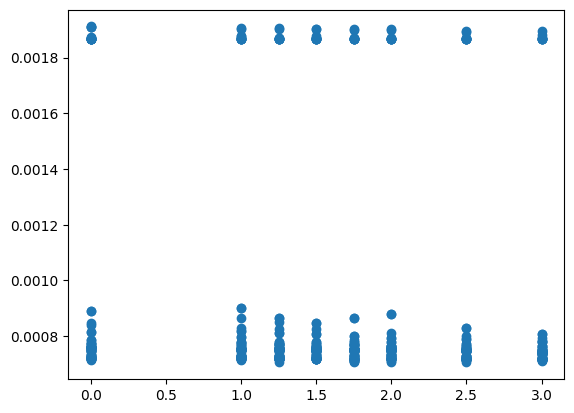

In [17]:
feature = 'train_focal_loss_gamma'

f = df[feature].values
val_loss = df['min_val_loss'].values

plt.plot(f, val_loss, 'o')

In [22]:
print(df.columns)

Index(['index', 'level', 'model_name', 'state', 'reweight_train_data_density',
       'min_val_loss', 'timestamp', 'build_activations', 'build_feature_cols',
       'build_hidden_sizes', 'build_num_classes', 'build_target_cols',
       'train_batch_size', 'train_device', 'train_early_stopping',
       'train_epochs', 'train_focal_loss_alpha',
       'train_focal_loss_alpha_schedule', 'train_focal_loss_gamma',
       'train_focal_loss_gamma_schedule', 'train_grad_clip_norm',
       'train_lambda_reg', 'train_loss', 'train_lr', 'train_lr_scheduler',
       'train_optimizer', 'train_regularization_type', 'train_weights_data'],
      dtype='object')


In [35]:
def plot_param_vs_val_loss(df: pd.DataFrame):
    params_to_plot = df.columns.tolist()
    rm = {'index', 'level', 'model_name', 'state', 'min_val_loss', 'timestamp'}
    for r in rm:
        if r in params_to_plot:
            params_to_plot.remove(r)
    for r in params_to_plot.copy():
        if df[r].nunique() == 1 and r in params_to_plot:
            params_to_plot.remove(r)

    n_cols = 3
    n_rows = int(np.ceil(len(params_to_plot) / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    for i, param in enumerate(params_to_plot):
        print(f'Plotting {param} ({i+1}/{len(params_to_plot)})')
        row = i // n_cols
        col = i % n_cols
        ax = axs[row, col] if n_rows > 1 else axs[col]
        values = df[param].values
        if any(type(v) in [int, float, bool] for v in values):
            values = values.astype(float)
        if df[param].nunique() == 1:
            continue
        ax.scatter(values, df['min_val_loss'].values)
        ax.set_yscale('log')
        ax.set_xlabel(param)
        ax.set_ylabel('Min validation loss')
        ax.set_title(f'{param}')
    return fig, axs

Plotting train_focal_loss_gamma (1/4)
Plotting train_lambda_reg (2/4)
Plotting train_lr (3/4)
Plotting train_lr_scheduler (4/4)


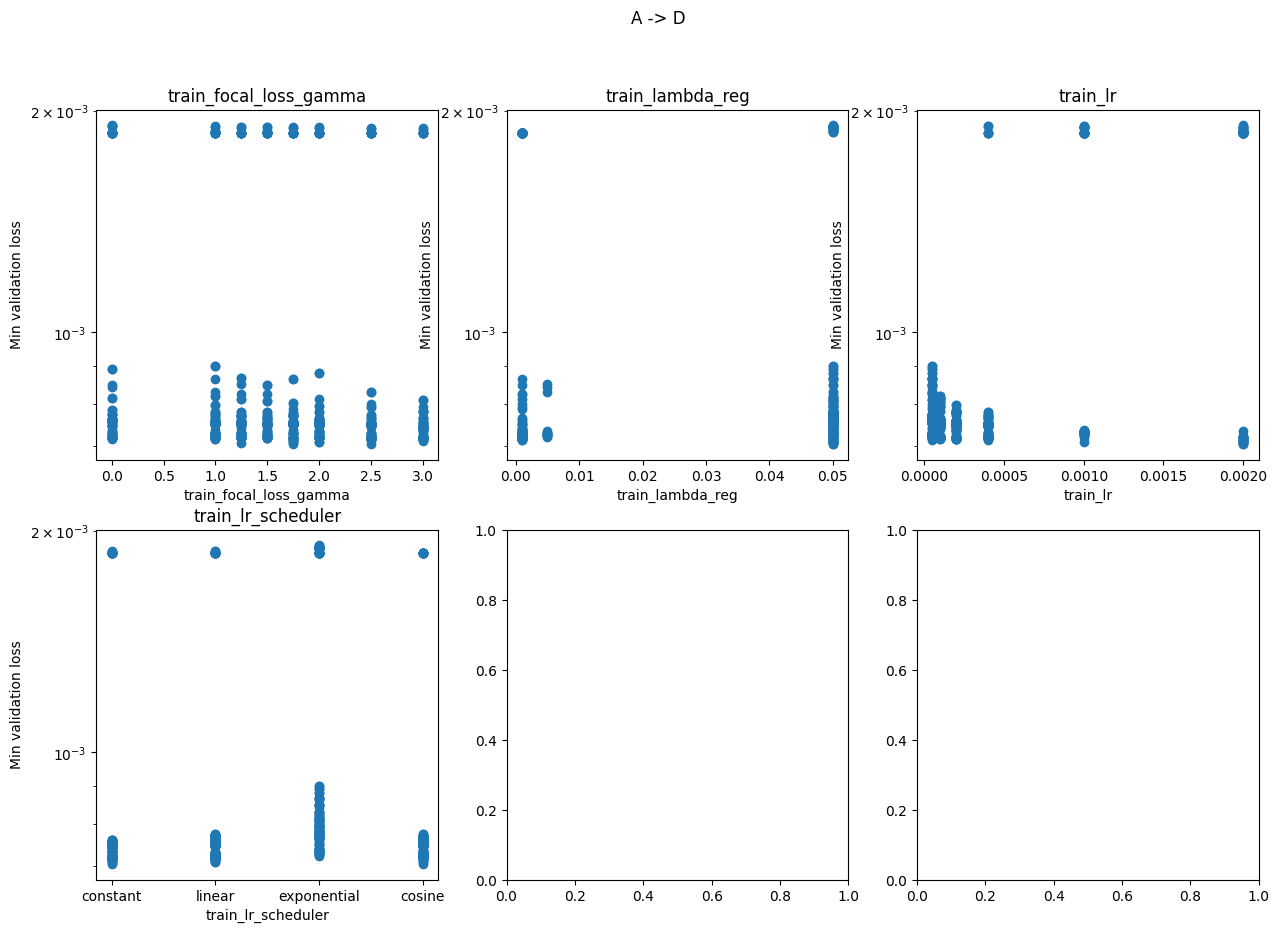

Plotting train_focal_loss_gamma (1/4)
Plotting train_lambda_reg (2/4)
Plotting train_lr (3/4)
Plotting train_lr_scheduler (4/4)


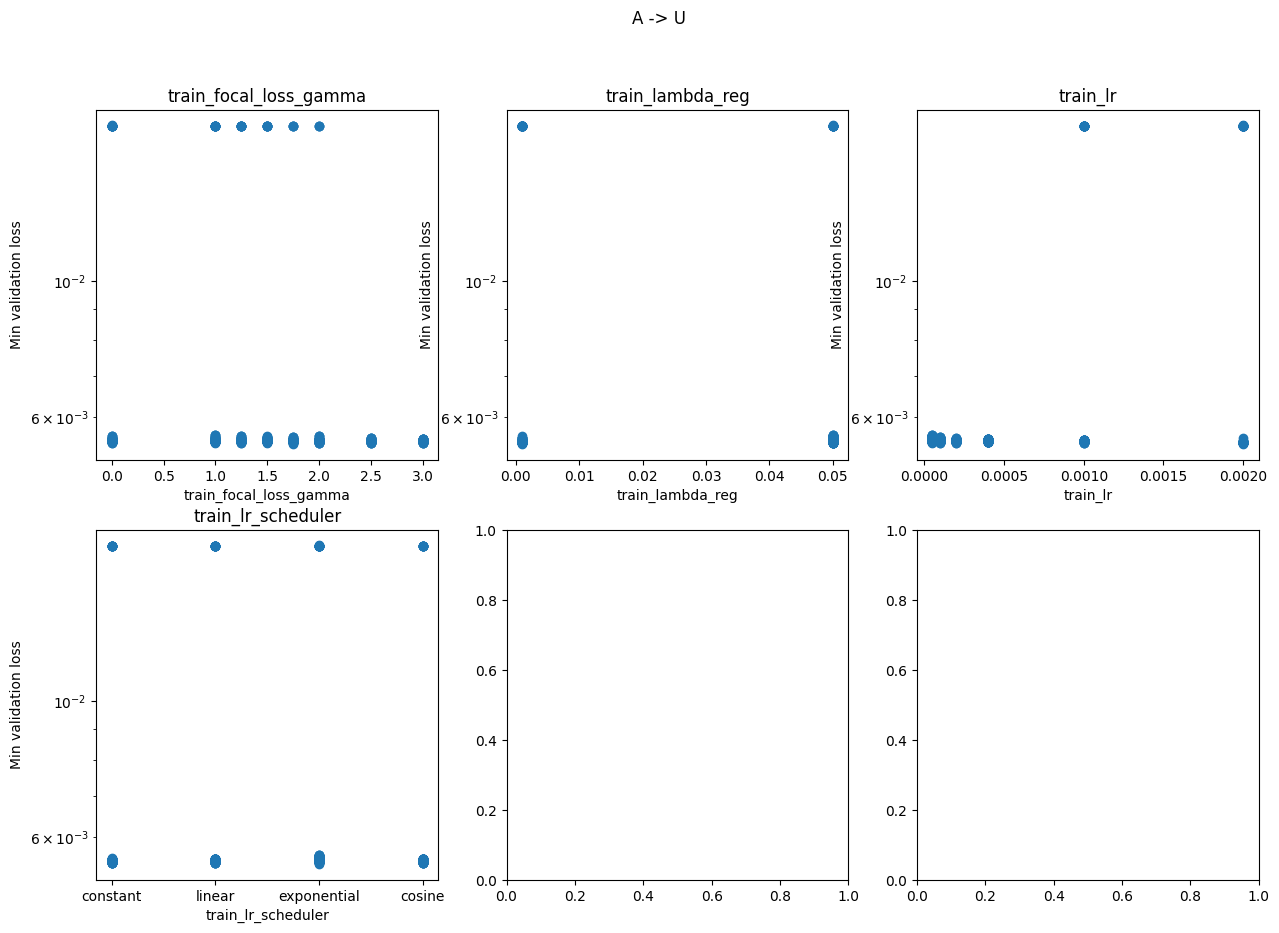

Plotting train_focal_loss_gamma (1/3)
Plotting train_lr (2/3)
Plotting train_lr_scheduler (3/3)


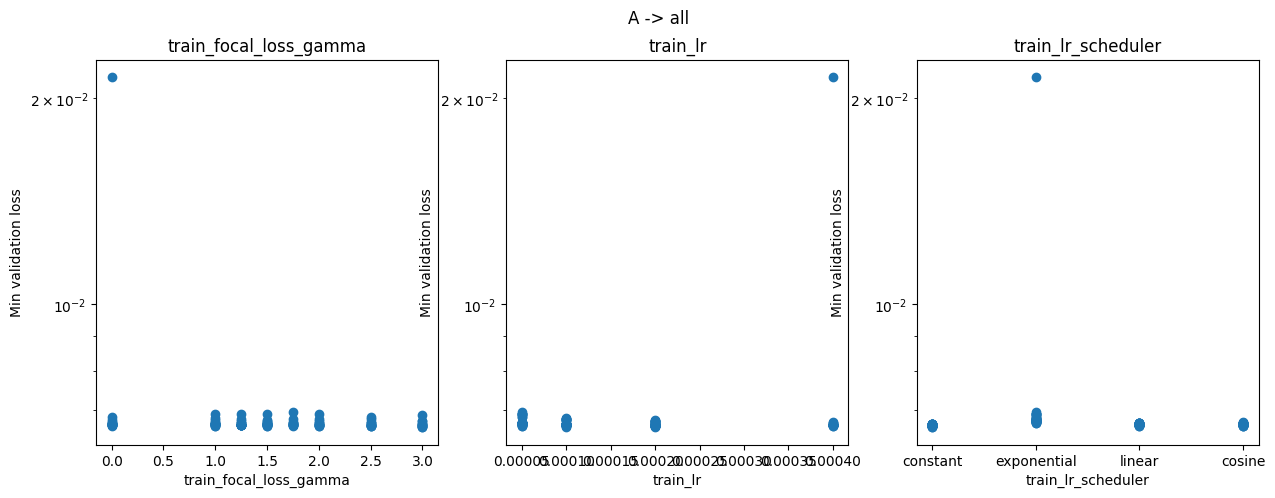

Plotting train_focal_loss_gamma (1/4)
Plotting train_lambda_reg (2/4)
Plotting train_lr (3/4)
Plotting train_lr_scheduler (4/4)


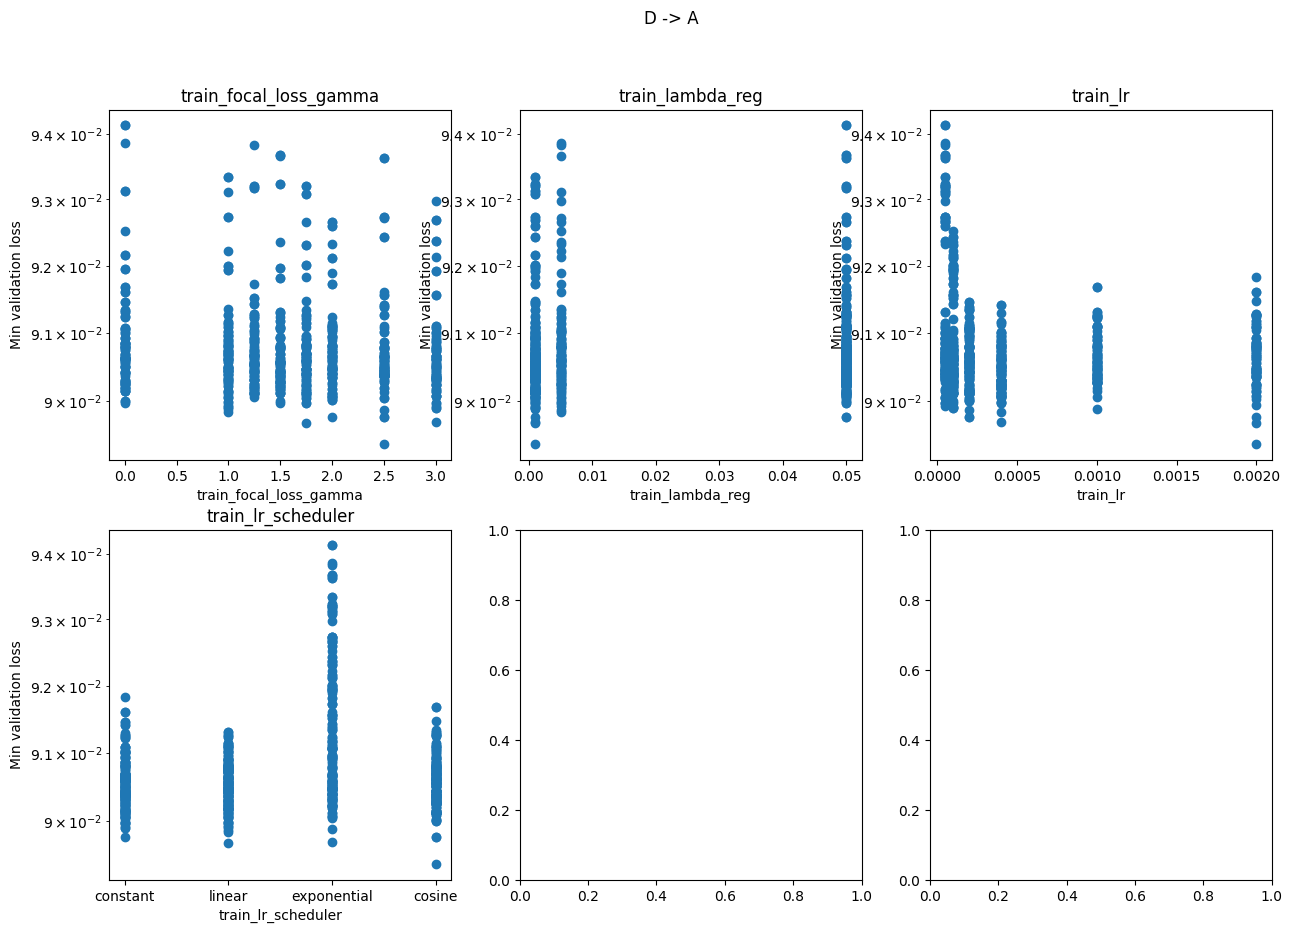

Plotting train_focal_loss_gamma (1/4)
Plotting train_lambda_reg (2/4)
Plotting train_lr (3/4)
Plotting train_lr_scheduler (4/4)


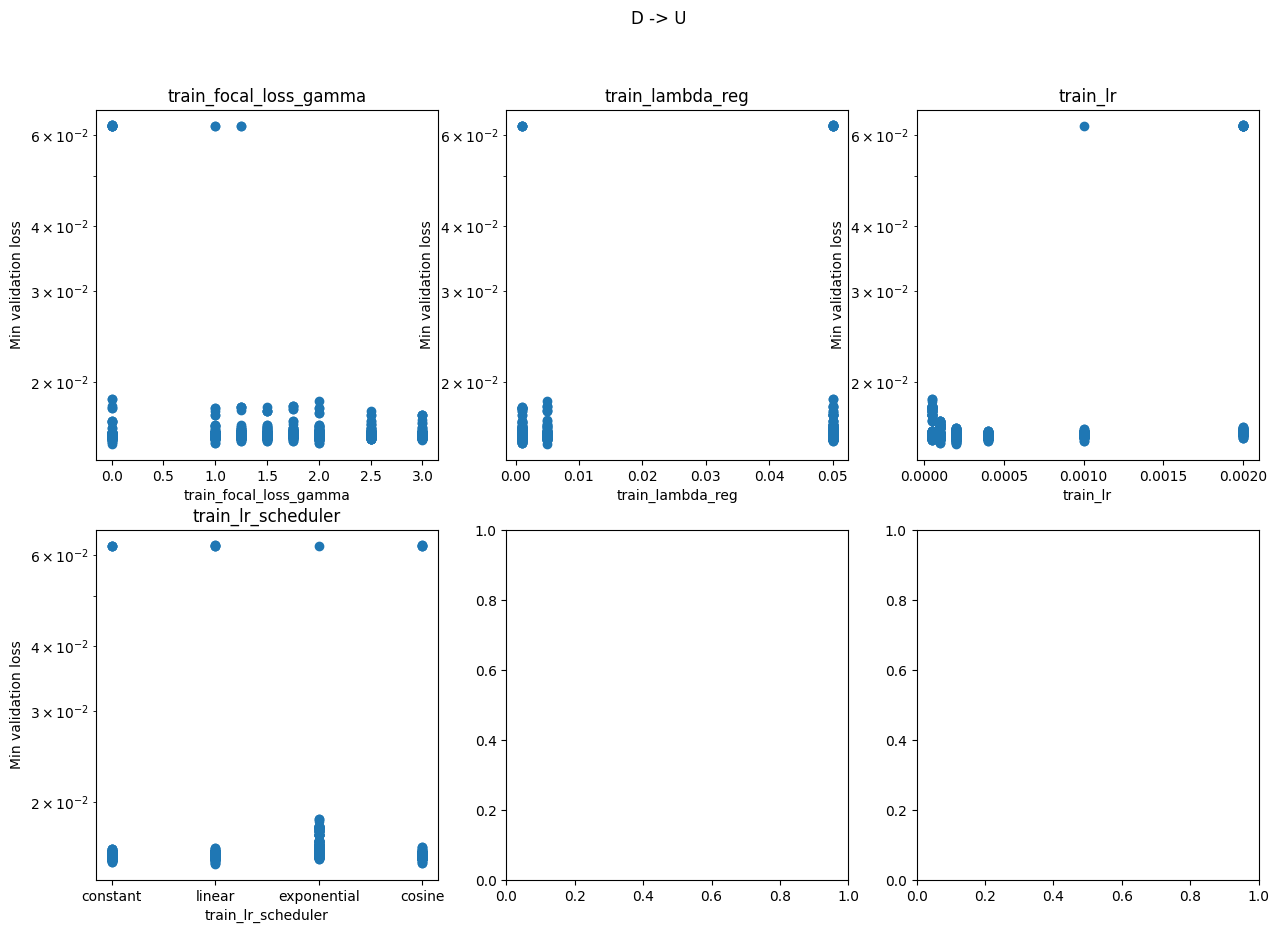

Plotting train_focal_loss_gamma (1/4)
Plotting train_lambda_reg (2/4)
Plotting train_lr (3/4)
Plotting train_lr_scheduler (4/4)


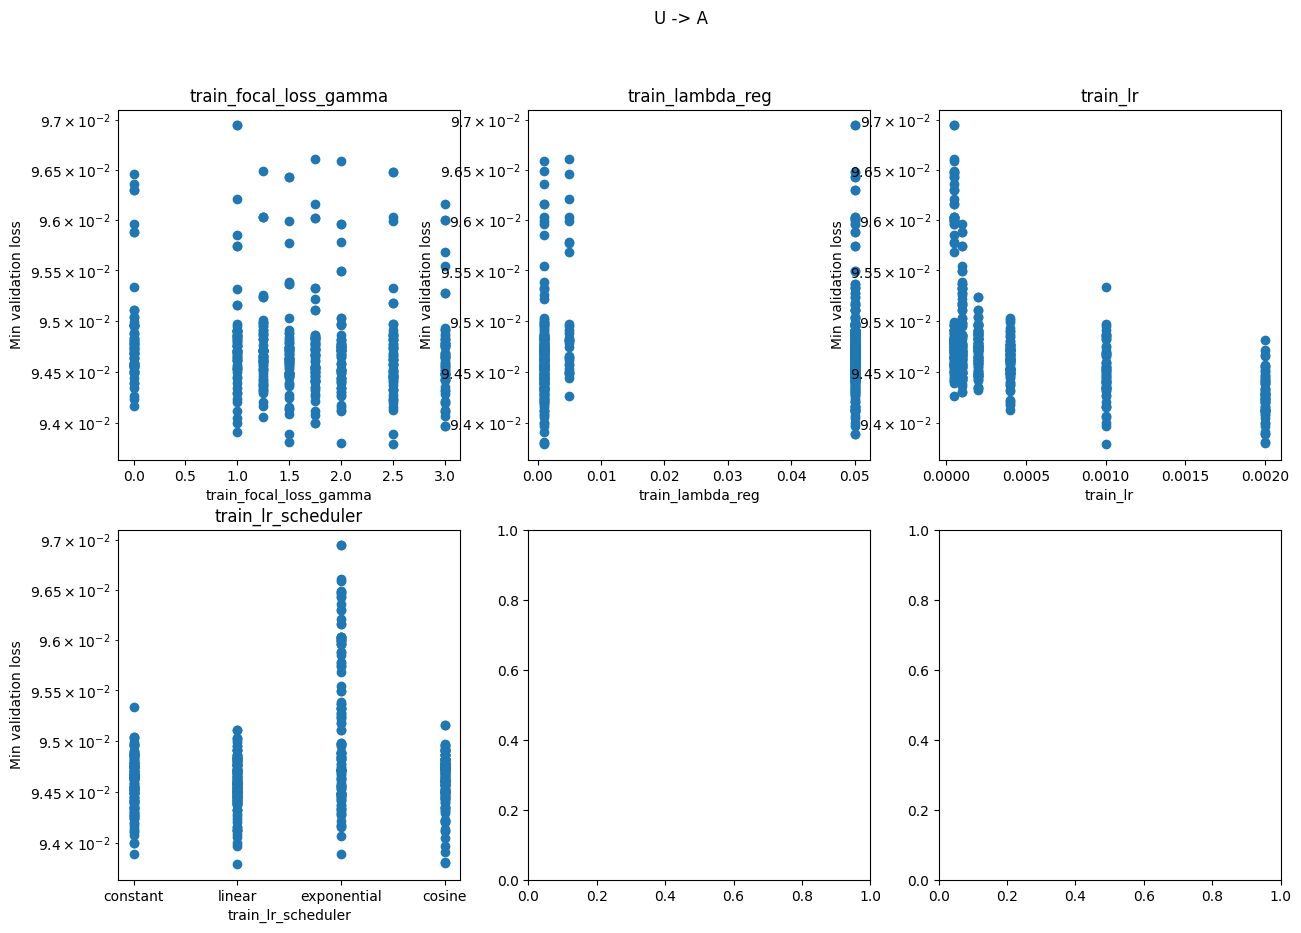

Plotting train_focal_loss_gamma (1/4)
Plotting train_lambda_reg (2/4)
Plotting train_lr (3/4)
Plotting train_lr_scheduler (4/4)


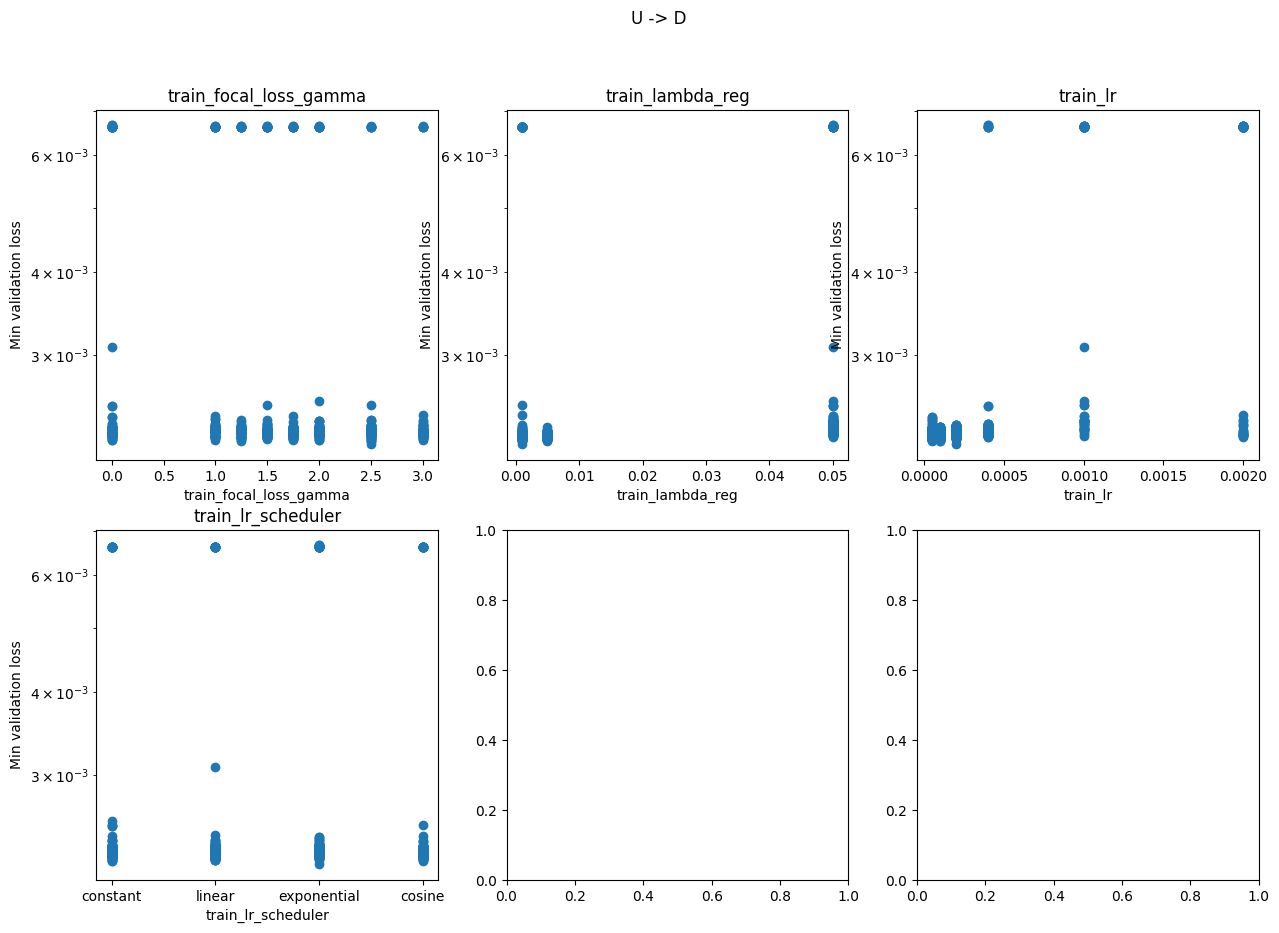

In [36]:
for (i,f, _), df in grid_searches.items():
    # print(f'\nPlotting for {i} -> {f}')
    fig, axs = plot_param_vs_val_loss(df)
    plt.suptitle(f'{i} -> {f}')
    plt.show()



Plotting train_focal_loss_gamma (1/4)
Plotting train_lambda_reg (2/4)
Plotting train_lr (3/4)
Plotting train_lr_scheduler (4/4)


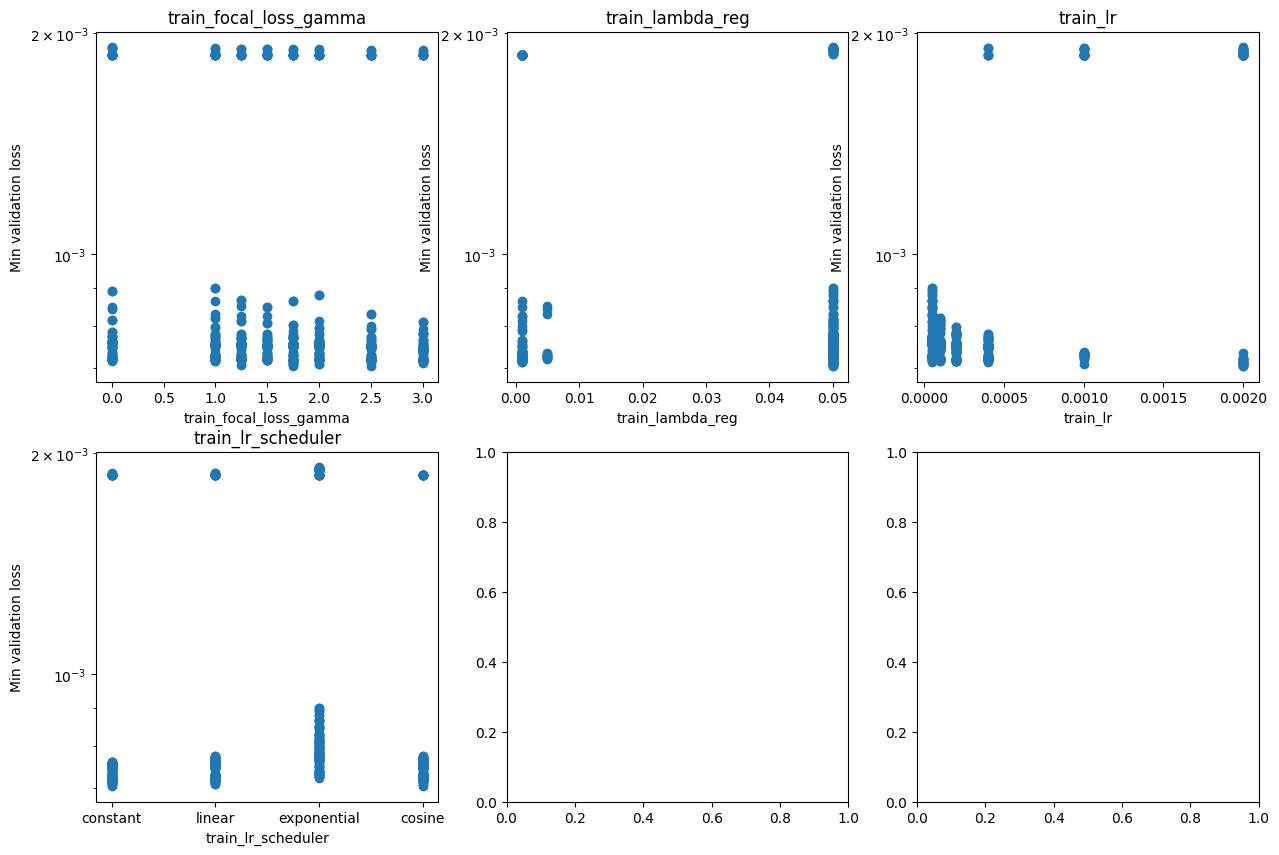

In [32]:
plot_param_vs_val_loss(df)